In [20]:
import time
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import arabic_reshaper
from PIL import ImageFont, ImageDraw, Image
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.xception import preprocess_input
from bidi.algorithm import get_display  # Ensure proper Arabic text display


In [ ]:
# ------------------------------
# 1. DATA LOADING & PREPROCESSING
# ------------------------------

# Adjust the image size to 299*299 to match Xception's input requirements.
dataset_path = 'RGB ArSL dataset'  # Main folder with subfolders for each letter

In [ ]:
def load_dataset(folder):
    """Load dataset from the folder containing subfolders for each letter."""
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize image to 299*299
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (299, 299))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [9]:
# Load images and labels
X, y = load_dataset(dataset_path)

In [10]:
# Encode labels to integers and then to one-hot vectors
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [11]:
# Save label classes for later inference
np.save('label_classes.npy', label_encoder.classes_)

In [ ]:
# Create a dynamic label map based on the encoder's order
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"Label Map: {label_map}")  # Ensure it matches your expectations

In [12]:
# Mapping from English label names to Arabic letters
english_to_arabic = {
    'Ain': 'ع', 'Al': 'ال', 'Alef': 'ا', 'Beh': 'ب', 'Dad': 'ض', 'Dal': 'د',
    'Feh': 'ف', 'Ghain': 'غ', 'Hah': 'ح', 'Heh': 'ه', 'Jeem': 'ج', 'Kaf': 'ك',
    'Khah': 'خ', 'Laa': 'لا', 'Lam': 'ل', 'Meem': 'م', 'Noon': 'ن', 'Qaf': 'ق',
    'Reh': 'ر', 'Sad': 'ص', 'Seen': 'س', 'Sheen': 'ش', 'Tah': 'ط', 'Teh': 'ت',
    'Teh_Marbuta': 'ة', 'Thal': 'ذ', 'Theh': 'ث', 'Waw': 'و', 'Yeh': 'ي',
    'Zah': 'ظ', 'Zain': 'ز', 'masafa': ' ', 'mash': ''  # 'mash' represents delete
}

In [ ]:
# Create a dynamic label map based on the encoder's order
label_map = {i: english_to_arabic[label] for i, label in enumerate(label_encoder.classes_)}
print(f"Label Map: {label_map}")  # Ensure it matches your expectations

In [15]:
#Xception expects inputs normalized with scale [-1, 1] instead of [0,1] 
X = preprocess_input(X)  # Replace X = X / 255.0

In [16]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [ ]:
# ------------------------------
# 2. BUILD THE XCEPTION-BASED MODEL
# ------------------------------

def create_xception_model():
    """
    Create an Xception-based model for Arabic Sign Language recognition.
    Uses ImageNet pre-trained weights with custom top layers.
    """
    # Load the Xception base model without the top layers
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    # Freeze most of the base model layers (fine-tuning will be done later)
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), use_bias=False),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu',use_bias=False),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu',use_bias=False),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu',use_bias=False),
        BatchNormalization(),
        Dropout(0.3),
        
        # Final softmax output for multi-class classification
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    return model


In [14]:
# Create and compile the model
model = create_xception_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,658,697 (90.25 MB)

 Trainable params: 8,289,697 (31.62 MB)

 Non-trainable params: 15,369,000 (58.63 MB)

In [19]:
# ------------------------------
# 3. DATA AUGMENTATION & MODEL TRAINING
# ------------------------------

# Enhanced data augmentation parameters.
# Note: Since the images are already normalized to [0, 1], the channel_shift_range value is omitted.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
# Compute balanced class weights based on the training data
y_train_int = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: 1.0477550372838331, 1: 0.9055258467023173, 2: 0.8894276094276095, 3: 0.8004848484848485, 4: 0.9351458510337015, 5: 1.093558536181487, 6: 0.9906990699069907, 7: 1.0107131925313744, 8: 1.0210265924551638, 9: 0.9667691406821841, 10: 1.1702994860889597, 11: 0.9809863339275104, 12: 0.9762010347376201, 13: 0.897404538660144, 14: 0.9762010347376201, 15: 1.005634231764885, 16: 1.0532695374800638, 17: 1.1911976911976911, 18: 1.064474532559639, 19: 0.9264870931537598, 20: 0.9667691406821841, 21: 0.9307963354474983, 22: 1.1771836007130125, 23: 0.7609171563544187, 24: 1.0006060606060605, 25: 1.2746574020459371, 26: 0.8201689021361153, 27: 0.9906990699069907, 28: 0.8933982683982684, 29: 1.0532695374800638, 30: 1.3706932337069324, 31: 1.220251293422025, 32: 1.2055494706097116}


In [21]:
# Set up callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_asl_xception_model.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

In [22]:
# ----------- Phase 1: Train with Frozen Base -----------
initial_epochs = 30
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 191s 898ms/step - accuracy: 0.0489 - loss: 17.8225 - val_accuracy: 0.1459 - val_loss: 16.3387 - learning_rate: 1.0000e-04
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 188s 911ms/step - accuracy: 0.1192 - loss: 16.5273 - val_accuracy: 0.2452 - val_loss: 15.3215 - learning_rate: 1.0000e-04
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 193s 933ms/step - accuracy: 0.1871 - loss: 15.4357 - val_accuracy: 0.3081 - val_loss: 14.3031 - learning_rate: 1.0000e-04
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 189s 913ms/step - accuracy: 0.2466 - loss: 14.4217 - val_accuracy: 0.4062 - val_loss: 13.1791 - learning_rate: 1.0000e-04
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 191s 922ms/step - accuracy: 0.2936 - loss: 13.4474 - val_accuracy: 0.4328 - val_loss: 12.3532 - learning_rate: 1.0000e-04
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 190s 920ms/step - accuracy: 0.3537 - loss: 12.4977 - val_accuracy: 0.5048 - val_loss: 11.3705 - learning_rate: 1.0000e-04
Epoch 7/30
207/207 ━━━━━━━━━

In [23]:
# Print Xception block names
base_model = model.layers[0]
for idx, layer in enumerate(base_model.layers):
    if "block" in layer.name:
        print(f"Layer {idx}: {layer.name}")

Layer 1: block1_conv1
Layer 2: block1_conv1_bn
Layer 3: block1_conv1_act
Layer 4: block1_conv2
Layer 5: block1_conv2_bn
Layer 6: block1_conv2_act
Layer 7: block2_sepconv1
Layer 8: block2_sepconv1_bn
Layer 9: block2_sepconv2_act
Layer 10: block2_sepconv2
Layer 11: block2_sepconv2_bn
Layer 13: block2_pool
Layer 16: block3_sepconv1_act
Layer 17: block3_sepconv1
Layer 18: block3_sepconv1_bn
Layer 19: block3_sepconv2_act
Layer 20: block3_sepconv2
Layer 21: block3_sepconv2_bn
Layer 23: block3_pool
Layer 26: block4_sepconv1_act
Layer 27: block4_sepconv1
Layer 28: block4_sepconv1_bn
Layer 29: block4_sepconv2_act
Layer 30: block4_sepconv2
Layer 31: block4_sepconv2_bn
Layer 33: block4_pool
Layer 36: block5_sepconv1_act
Layer 37: block5_sepconv1
Layer 38: block5_sepconv1_bn
Layer 39: block5_sepconv2_act
Layer 40: block5_sepconv2
Layer 41: block5_sepconv2_bn
Layer 42: block5_sepconv3_act
Layer 43: block5_sepconv3
Layer 44: block5_sepconv3_bn
Layer 46: block6_sepconv1_act
Layer 47: block6_sepconv1


In [24]:
# Unfreeze last 3 blocks by name
base_model = model.layers[0]
for layer in base_model.layers:
    layer.trainable = False  # Freeze all first

for layer in base_model.layers:
    if any([block in layer.name for block in ["block12_sepconv1", "block13_sepconv1", "block14_sepconv1"]]):
        layer.trainable = True

In [25]:
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
fine_tune_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
datagen.flow(X_train, y_train, batch_size=32),
validation_data=(X_val, y_val),
epochs=total_epochs,
initial_epoch=initial_epochs,
class_weight=class_weights,
callbacks=callbacks
)

Epoch 31/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 198s 931ms/step - accuracy: 0.8422 - loss: 1.2092 - val_accuracy: 0.8130 - val_loss: 1.2957 - learning_rate: 1.0000e-05
Epoch 32/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 192s 928ms/step - accuracy: 0.8429 - loss: 1.1708 - val_accuracy: 0.8075 - val_loss: 1.2759 - learning_rate: 1.0000e-05
Epoch 33/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 191s 925ms/step - accuracy: 0.8555 - loss: 1.1184 - val_accuracy: 0.8154 - val_loss: 1.2568 - learning_rate: 1.0000e-05
Epoch 34/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 192s 928ms/step - accuracy: 0.8505 - loss: 1.1093 - val_accuracy: 0.8148 - val_loss: 1.2380 - learning_rate: 1.0000e-05
Epoch 35/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 194s 939ms/step - accuracy: 0.8527 - loss: 1.0804 - val_accuracy: 0.8196 - val_loss: 1.2203 - learning_rate: 1.0000e-05
Epoch 36/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 196s 948ms/step - accuracy: 0.8696 - loss: 1.0370 - val_accuracy: 0.8190 - val_loss: 1.2065 - learning_rate: 1.0000e-05
Epoch 37/55
207/207 ━━━━━━━━━━━━━━

In [26]:
# Save the final model
model.save('asl_xception_model.keras')

In [15]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

NameError: name 'X_val' is not defined

In [ ]:
# ------------------------------
# 3.1: Evaluation Metrics & Analysis on Validation Set
# ------------------------------

# Predict on validation set
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 580ms/step


In [29]:
# Print classification report
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

         Ain       0.91      0.79      0.85        53
          Al       0.81      0.93      0.86        55
        Alef       0.98      0.95      0.97        62
         Beh       0.84      0.82      0.83        57
         Dad       0.91      0.94      0.92        52
         Dal       0.69      0.71      0.70        52
         Feh       0.60      0.64      0.62        53
       Ghain       0.79      0.84      0.82        32
         Hah       0.76      0.84      0.80        50
         Heh       0.68      0.85      0.76        46
        Jeem       0.89      0.79      0.84        39
         Kaf       0.77      0.77      0.77        60
        Khah       0.79      0.82      0.80        45
         Laa       0.82      0.93      0.88        45
         Lam       0.94      0.89      0.92        55
        Meem       0.79      0.76      0.77        54
        Noon       0.76      0.94      0.84        47
    

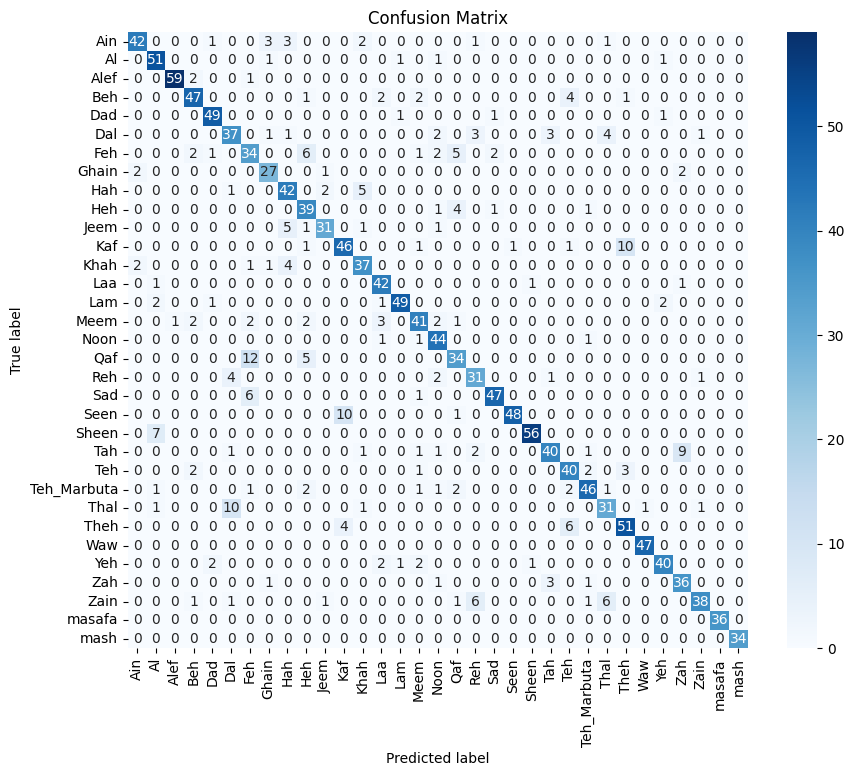

In [30]:
# Plot confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# ------------------------------
# 4. REAL-TIME ARSL INFERENCE VIA WEBCAM
# ------------------------------

# Reload the saved model and labels
model = load_model('asl_xception_model.keras')

# Load label encoder and define label map dynamically
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_classes.npy', allow_pickle=True)
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

# Initialize webcam
cap = cv2.VideoCapture(0)
captured_letters = []  # Store the formed sentence
last_predicted_label = None  # Track the previous prediction
frames_with_same_letter = 0  # Counter for consistent frames
cooldown_threshold = 7  # Threshold for consecutive frames with the same prediction
last_activity_time = time.time()  # Track time for inactivity
idle_timeout = 15  # Inactivity time limit (seconds)

# def format_arabic_text(letters):
#     """Format Arabic text to display properly from right to left."""
#     reshaped_text = arabic_reshaper.reshape(''.join(letters))
#     return get_display(reshaped_text)  # Ensure correct Arabic rendering

def format_arabic_text(letters):
    """Format Arabic text to display properly from right to left."""
    return arabic_reshaper.reshape(''.join(letters))

def draw_text(frame, text, position):
    """Draw text on the video frame."""
    font = ImageFont.truetype("arial.ttf", 35)
    img_pil = Image.fromarray(frame)
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=(0, 255, 0))
    return np.array(img_pil)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Define Region of Interest (ROI)
    roi = frame[100:400, 100:400]
    cv2.rectangle(frame, (100, 100), (400, 400), (0, 255, 0), 2)

    # Preprocess ROI
    roi_resized = cv2.resize(roi, (299, 299))  # Resize to match model input
    roi_resized = preprocess_input(roi_resized)  # Apply model-specific preprocessing
    roi_resized = np.expand_dims(roi_resized, axis=0)  # Expand dimensions for batch processing

    # Predict the letter/gesture
    prediction = model.predict(roi_resized, verbose=0)
    confidence = np.max(prediction)
    predicted_id = np.argmax(prediction)
    predicted_label = label_map.get(predicted_id, '')

    # Confidence filtering: Avoid writing letters when nothing is detected
    if confidence < 0.7:  
        predicted_label = None

    # Check if the prediction is consistent
    if predicted_label == last_predicted_label:
        frames_with_same_letter += 1
    else:
        frames_with_same_letter = 0  # Reset if prediction changes

    # Register the letter only if it remains consistent for the threshold
    if frames_with_same_letter >= cooldown_threshold:
        if predicted_label == 'masafa':  # Space in Arabic
            captured_letters.append(' ')
        elif predicted_label == 'mash' and captured_letters:  # Delete last letter
            captured_letters.pop()
        elif predicted_label and predicted_label not in ['masafa', 'mash']:
            captured_letters.append(predicted_label)

        # Reset tracking variables
        last_predicted_label = None
        frames_with_same_letter = 0
        last_activity_time = time.time()  # Reset idle time

    else:
        last_predicted_label = predicted_label  # Update last prediction

    # Check for inactivity timeout
    if time.time() - last_activity_time > idle_timeout:
        print(f"Final Sentence: {format_arabic_text(captured_letters)}")
        break  # Exit loop if idle for too long

    # Format and display the text on the frame
    sentence = format_arabic_text(captured_letters)
    frame = draw_text(frame, sentence, (10, 30))

    # Show the frame
    cv2.imshow('ASL Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(f"Final Sentence: {format_arabic_text(captured_letters)}")
        break

cap.release()
cv2.destroyAllWindows()


Final Sentence: BehYehYehFehAlefAlefAlefAlefAinAin
